<img src="mioti.png" style="height: 100px">
<center style="color:#888">Módulo Data Science in IoT<br/>Asignatura Data preprocessing</center>

# Challenge S7: Clasificación de sentimientos en tweets

## Objetivos:

El objetivo de este challenge es enfrentarse a un problema de clasificación de texto real: tweets descargados sobre las elecciones de EEUU en 2016, centrándonos en el preprocesamiento, que en este caso es crucial en un problema en el que el protagonista es el texto.

## Inicialización del entorno:

In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import nltk
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier

import matplotlib.pyplot as plt
from wordcloud import WordCloud
import random

import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer

random.seed(1234)
pd.set_option('display.max_colwidth', 175) # incrementamos anchura de output

In [2]:
df_train = pd.read_csv('./data/gop_tweets_train_psn.csv')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8414 entries, 0 to 8413
Data columns (total 2 columns):
sentiment    8414 non-null object
text         8414 non-null object
dtypes: object(2)
memory usage: 131.5+ KB


In [3]:
df_test = pd.read_csv('./data/gop_tweets_test_psn.csv')
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2153 entries, 0 to 2152
Data columns (total 2 columns):
sentiment    2153 non-null object
text         2153 non-null object
dtypes: object(2)
memory usage: 33.7+ KB


Damos un vistazo a los textos que aparecen en el dataset.

In [4]:
df_train.head()

,sentiment,text
0,Neutral,RT @NancyLeeGrahn: How did everyone feel about the Climate Change question last night? Exactly. #GOPDebate
1,Positive,RT @ScottWalker: Didn't catch the full #GOPdebate last night. Here are some of Scott's best lines in 90 seconds. #Walker16 http://t.co/ZSfF…
2,Neutral,RT @TJMShow: No mention of Tamir Rice and the #GOPDebate was held in Cleveland? Wow.
3,Positive,RT @RobGeorge: That Carly Fiorina is trending -- hours after HER debate -- above any of the men in just-completed #GOPdebate says she's on …
4,Positive,RT @DanScavino: #GOPDebate w/ @realDonaldTrump delivered the highest ratings in the history of presidential debates. #Trump2016 http://t.co…


In [5]:
df_test.head()

,sentiment,text
0,Positive,"RT @GregAbbott_TX: @TedCruz: ""On my first day I will rescind every illegal executive action taken by Barack Obama."" #GOPDebate @FoxNews"
1,Neutral,Going on #MSNBC Live with @ThomasARoberts around 2 PM ET. #GOPDebate
2,Positive,RT @WayneDupreeShow: Just woke up to tweet this out #GOPDebate \r\n\r\nBest line of the night via @GovMikeHuckabee http://t.co/6OV5hxHIcV
3,Negative,reason comment is funny 'in case you're ignorant' is the #gop #tcot are the reason the government isn't working for the people #gopdebate
4,Positive,"RT @ChuckNellis: Cruz has class &amp; truth, that gets my vote! #GOPDebate"


## ¿Qué número de tweets tenemos en cada dataset? ¿Cuántos de cada clase?

In [6]:
df_train.count()

sentiment    8414
text         8414
dtype: int64

In [7]:
df_test.count()

sentiment    2153
text         2153
dtype: int64

In [8]:
df_train['sentiment'].value_counts()

Negative    4872
Neutral     2162
Positive    1380
Name: sentiment, dtype: int64

In [9]:
df_test['sentiment'].value_counts()

Negative    1257
Neutral      567
Positive     329
Name: sentiment, dtype: int64

## ¿Qué dificultades crees que presenta la diferencia entre la cantidad de clases?

La variedad en el número de clases puede ocasionar dificultades de clasificación y predicción, ya que es un dataset muy desbalanceado y los casos minoritarios pueden ser complejos de clasificar. 

## Clasificador de tweets

Vamos a construir nuestro propio clasificador sobre los tweets que hemos cargado. Los pasos que seguiremos serán:

* Preprocesar ambos conjuntos de tweets por separado.
* Entrenar clasificador con tweets de entrenamiento.
* Evaluar con tweets de test.

Primero, haremos una prueba para observar el rendimiento de nuestro clasificador sin ningún tipo de preprocesamiento.

In [10]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

Seguimos creando el clasificador y entrenando con el conjunto de entrenamiento de los tweets.

In [11]:
# creamos nuestro pipeline con vectorizador (bag of words) y clasificador
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('clf', LinearSVC(max_iter=1200))])

# entrenamos el clasificador
text_clf.fit(df_train['text'], df_train['sentiment'])

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...ax_iter=1200,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

Realizamos las predicciones con el conjunto de test y obtenemos la métrica de evaluación.

In [12]:
predicted = text_clf.predict(df_test['text'])
np.mean(predicted == df_test['sentiment'])

0.5973060845332094

Parece que hemos obtenido un resultado un poco peor... Ahora es cuando entra en juego el preprocesamiento del texto.

Ahora vamos a preprocesar el texto y construir un clasificador. Para ello, se ha creado esta función que nos automatiza el preprocesamiento. Deberás añadir el código que creas necesario y ejecutar la función para obtener el texto preprocesado. 

**Puedes definir todas las funciones de preprocesado que creas necesario, pero ten en cuenta varios detalles:**
* La funcion `preprocesar_texto` es llamada desde un `apply`. Esto significa que la función recibe un tweet y devuelve un tweet preprocesado con cada llamada. 
* Si el preprocesado es muy agresivo, un tweet puede quedarse fácilmente vacío, en esos casos el clasificador no podrá trabajar con él y escupirá la clase mayoritaria para ese tweet.
* Algunas técnicas no tienen sentido si se aplican después de otras dentro del pipeline. Por ejemplo, no tiene sentido aplicar POS después de realizar Stemming.
* Count Vectorizer necesita DOCUMENTOS y al trabajar con texto muchas veces es más sencillo hacer uso de TOKENS. Esto significa que tendremos que pasar cada tweet preprocesado en una cadena de texto. La función `" ".join(palabras)` que vimos en el worksheet es tu aliada.
* Si tu preprocesamiento va a ser intensivo, quizás es buena idea crear varias funciones que sean llamadas desde `preprocesar_texto`.

In [13]:
#Definición de las funciones de pre-preprocesado a usar en la función preprocesar_texto

def tokenizar(chain):
    import nltk
    from nltk.tokenize import word_tokenize
    from nltk.tokenize import TweetTokenizer
    token_words = TweetTokenizer().tokenize(chain)
    
    return token_words

def pos_text(words):
    from nltk import pos_tag
    postext = []
    for pos in pos_tag(words):
        if pos[1].startswith('JJ'):
            #if pos[0] is not None:
            postext.append(pos[0])
        
    return postext

def stem_text(text):
    from nltk.stem import SnowballStemmer
    stemmer = SnowballStemmer("english")
    palabras_stem = []
    for palabra in text:
        palabras_stem.append(stemmer.stem(palabra))
            
    return palabras_stem        
    


def preprocesar_texto(texto):

    """ Función para preprocesamiento de texto.
    Args:
        texto: cadena de texto a preprocesar.
    Returns:
        mismo texto preprocesado.
    """

    texto_filtrado = ""
    palabras = tokenizar(texto)
    palabras = pos_text(palabras)
    #palabras = stem_text(palabras)
    texto_filtrado = ' '.join(palabras) 
    
    return texto_filtrado

Aplicamos el preprocesamiento a los dos conjuntos de tweets y lo guardamos en la columna `prep`.

In [14]:
df_train['prep'] = df_train['text'].apply(preprocesar_texto)
df_test['prep'] = df_test['text'].apply(preprocesar_texto)

Antes de reentrenar nuestro clasificador, siempre es recomendable dar un vistazo al resultado del texto. Podemos observar frecuencia de palabras o simplemente generar un WordCloud.

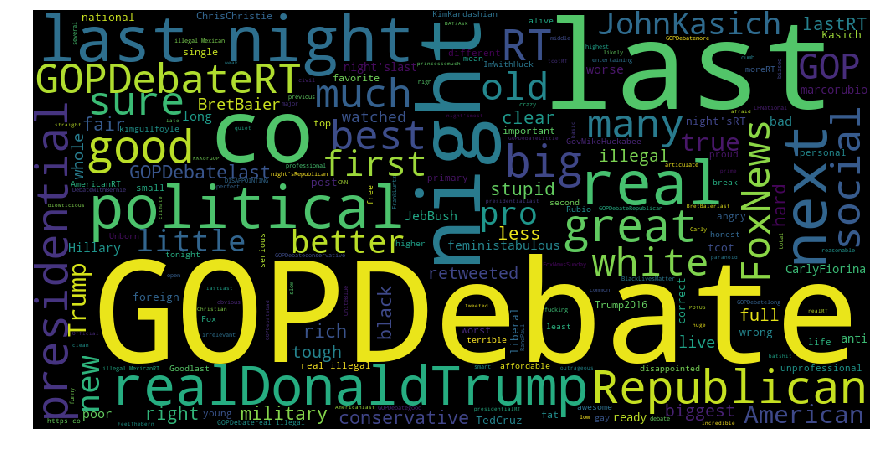

'highest presidential'

In [15]:
# AQUÍ TU CÓDIGO
from wordcloud import WordCloud
#Antes de lanzar WordCloud, se concatena todos los tweets preprocesados en un solo string
string = ""
for tweet in df_train['prep']:
    string = string + tweet
    
wordcloud = WordCloud(width = 1000, height = 500, relative_scaling = 0.5).generate(string)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()
df_train['prep'][4]


Ahora sí, vamos a reentrenar el clasificador y evaluar de nuevo. Puedes hacer uso del mismo pipeline anterior o simplemente crear uno nuevo con más etapas.

In [16]:
# Nuevo pipeline si es que es necesario. Por defecto usamos el anterior.
new_clf = text_clf
new_clf.fit(df_train['prep'], df_train['sentiment'])

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...ax_iter=1200,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

In [17]:
# Predicción haciendo uso del pipeline correspondiente. ¡Recuerda cambiarlo si has creado uno nuevo!
predicted = new_clf.predict(df_test['prep'])
np.mean(predicted == df_test['sentiment'])

0.5819786344635393

* ¿Qué opinas de los resultados obtenidos?
* ¿Por qué crees que ha sucedido esto?

Los resultados muestran poco cambio con respecto al dataset original. He aplicado diferentes estrategias y funciones combinadas - aplicaar tokenizar, pos, stem con diferentes combinaciones - y en ningún caso se observa una mejora sustancial.

En principio esto podría ocurrir porque en preprocesado que usamos no aplica inteligencia en cuanto a contenido, significado o número de observaciones por palabra; es decir se aplica un pre-procesado en la gramática sin tener en cuenta el significado o repetición de las palabras.

¿Podrías explicarme con tus palabras en qué consiste Tf-Idf? ¿Cual es la idea intuitiva de aplicar esta transformación a la matriz?

Es una función que contiene algoritmos para identificar la relevancia (o falta de relevancia en el caso inverso) en términos de frecuencia de una palabra o grupo de palabras dentro de un texto o varios documentos. 

En principio esto podría ayudar en el pre-procesado en nuetro caso, ya que ayudaría a eliminar términos repetitivos sin significado, así como enfatizar los contenidos más relevantes para poder mantenerlos a la hora de entrenar el modelo y predecir

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

tf_clf = Pipeline([('vect', CountVectorizer(tokenizer = TweetTokenizer().tokenize)),
                     ('tfidf', TfidfTransformer(use_idf = True, smooth_idf=True)),
                     ('clf', LinearSVC())])

In [19]:
tf_clf.fit(df_train['prep'], df_train['sentiment'])

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

In [20]:
predicted = tf_clf.predict(df_test['prep'])

In [21]:
print("Accuracy: {:.2f}%".format(np.mean(predicted == df_test['sentiment'])))

Accuracy: 0.58%


No se observa una gran mejora, aunque entiendo que podría mejorarse con algún parámetro específico y analizando a detalle las funciones tf-idf